<a href="https://colab.research.google.com/github/SujayVivek/TradingStrategies/blob/main/APT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###SOLUTION:



In [65]:
pip install mplfinance

In [66]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import mplfinance as mpf

In [67]:
df = pd.read_csv('02_sample_data_with_fabricated_columns.csv')

Lets Determine the Volume Column:

Since volume must be a whole number, we are checking for the column with maximum number of whole numbers

In [70]:
ints = {c: ((df[c] % 1) == 0).mean() for c in df.columns}
means = {c: df[c].mean() for c in df.columns}
volume = max(df.columns, key=lambda c: (ints[c], means[c]))
left = [c for c in df.columns if c != volume]

volume


'neutronCount'

We got neutronCount as our Volume Column

To confirm, we can identify it as the volume that would have the most standard deviation amongst other columns, and the column with *'large numbers'*



In [71]:
stats = pd.DataFrame({
    'mean': df.mean(),
    'std': df.std(),
    'var': df.var()
})

In [72]:
print(stats.sort_values('std', ascending=False))

volume_candidate = stats['std'].idxmax()
print("volume candidate:", volume_candidate)

                      mean           std           var
neutronCount  50541.730472  28578.459770  8.167284e+08
flux             95.209804    103.797320  1.077388e+04
omega            95.016844    103.797184  1.077386e+04
gamma            95.402143    103.796594  1.077373e+04
deltaX           95.209593    103.796442  1.077370e+04
pulse            95.209737    103.796308  1.077367e+04
→ volume candidate: neutronCount


Clearly we have our Volume Candidate to be *NeutronCount*

In [73]:
vol_col = volume

We can create a correlation matrix, and we can expect the correlation of Volume with other fields will be low!

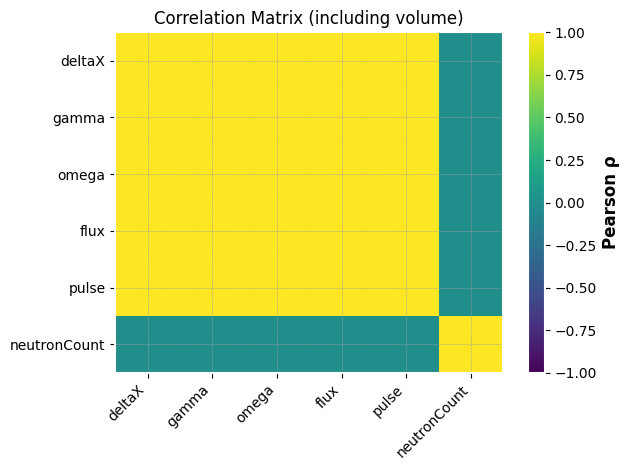

In [74]:
vars_ = ['deltaX', 'gamma', 'omega', 'flux', 'pulse', vol_col]
corr = df[vars_].corr()
plt.figure()
plt.imshow(corr, interpolation='none', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Pearson ρ')
plt.xticks(range(len(vars_)), vars_, rotation=45, ha='right')
plt.yticks(range(len(vars_)), vars_)
plt.title("Correlation Matrix (including volume)")
plt.tight_layout()
plt.show()

##To identify Open and Close:

In [76]:
results = []

We are iterating through each price, and for every price -> we are permuting all the remaining columns, for open, high, low and close

We are checking Open-Close Violations :


*   Every Open must be greater than Low, and smaller than High
*   Every close must be greater than Low, and smaller than High


We are checking Price Violations :


*   A Price must stay within the Low and High of every candlestick







In [119]:
for price in left:
    ohcl = [c for c in left if c != price]
    for o, h, l, c in itertools.permutations(ohcl, 4):
        oh_viol = ((df[l] > df[o]) | (df[o] > df[h]) | (df[l] > df[c]) | (df[c] > df[h])).sum()
        pr_viol = ((df[l] > df[price]) | (df[price] > df[h])).sum()
        results.append((oh_viol, pr_viol, price, o, h, l, c))

In [120]:
res = sorted(results, key=lambda x: (x[0], x[1]))
for entry in res[:10]:
    print(entry)



(np.int64(0), np.int64(134535), 'pulse', 'deltaX', 'gamma', 'omega', 'flux')
(np.int64(0), np.int64(134535), 'pulse', 'flux', 'gamma', 'omega', 'deltaX')
(np.int64(134535), np.int64(0), 'deltaX', 'flux', 'gamma', 'omega', 'pulse')
(np.int64(134535), np.int64(0), 'deltaX', 'pulse', 'gamma', 'omega', 'flux')
(np.int64(134535), np.int64(0), 'flux', 'deltaX', 'gamma', 'omega', 'pulse')
(np.int64(134535), np.int64(0), 'flux', 'pulse', 'gamma', 'omega', 'deltaX')
(np.int64(345916), np.int64(500000), 'gamma', 'deltaX', 'flux', 'omega', 'pulse')
(np.int64(345916), np.int64(500000), 'gamma', 'pulse', 'flux', 'omega', 'deltaX')
(np.int64(346076), np.int64(500000), 'omega', 'flux', 'gamma', 'deltaX', 'pulse')
(np.int64(346076), np.int64(500000), 'omega', 'pulse', 'gamma', 'deltaX', 'flux')


The above sorted order is based on OH violations. We lean so heavily on zero OH‐violations because the very definition of an OHLC bar is that the high is the maximum of everything that happened in the period and the low is the minimum. If you ever pick an “open” that sits outside [low,high], you’ve literally broken the shape of a candle

In [78]:
##So, we can guarantee that the first two rows have 0 OH violations, and that must be our choice!
#lets assume for now
open_col  = 'flux'
close_col = 'deltaX'

##High, Low and Price

For now we have assumed


*   Flux = Open
*   DeltaX = Close

We will re-confirm this later on!



In [79]:
df2 = pd.read_csv('02_sample_data_with_fabricated_columns.csv')
df2 = df.rename(columns={
    'flux':  'open',
    'deltaX':'close',
    'neutronCount':'volume'
})
# drop volume for now
df2 = df2.drop(columns=['volume'])

We are trying to see for every column:



*   Above has the mean of that number being greater than both open and close
*   Below has the mean of that number being lower than both open and close





In [80]:
candidates = [c for c in df2.columns if c not in ['open','close']]
metrics = []
for col in candidates:
    above = ((df2[col] >= df2['open']) & (df2[col] >= df2['close'])).mean()
    below = ((df2[col] <= df2['open']) & (df2[col] <= df2['close'])).mean()
    metrics.append((col, above, below, df2[col].median()))

In [81]:
metrics_df = pd.DataFrame(metrics, columns=['field','above_both','below_both','median']).set_index('field')
print("── Metrics for high/low/price candidates ──")
print(metrics_df, "\n")

── Metrics for high/low/price candidates ──
       above_both  below_both      median
field                                    
gamma     1.00000      0.0000  114.286186
omega     0.00000      1.0000  113.906685
pulse     0.24985      0.2497  114.092463 



Observation:


*   Gamma has a mean of 1 under *above_both*, therefore it should be the High Value
*   Omega has mean of 1 under *below_both*, therefore it should be the Low Value




Therefore price would be the column other than Gamma and Omega = Pulse

##Price, High & Low Reconfirmation

In [85]:
high_col = "gamma"
low_col = "omega"
price_col = "pulse"

In [86]:
df2 = df2.rename(columns={
    high_col:'high',
    low_col: 'low',
    price_col:'price'
})

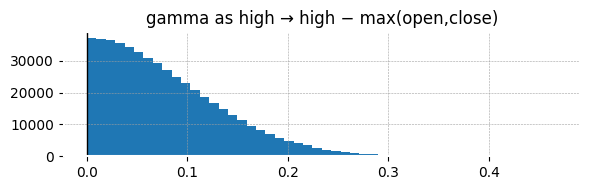

In [87]:
diff_high = df2['high'] - df2[['open','close']].max(axis=1)
plt.figure(figsize=(6,2))
plt.hist(diff_high, bins=50)
plt.axvline(0, color='k', lw=1)
plt.title(f"{high_col} as high → high − max(open,close)")
plt.tight_layout()
plt.show()

If gamma was High, then High - max(open, close) should be positive, as said in the above graph

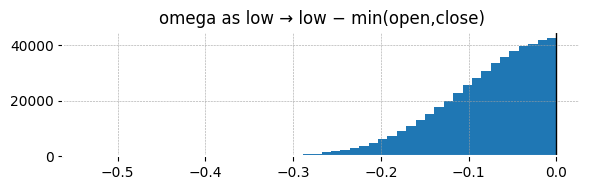

In [88]:
diff_low = df2['low'] - df2[['open','close']].min(axis=1)
plt.figure(figsize=(6,2))
plt.hist(diff_low, bins=50)
plt.axvline(0, color='k', lw=1)
plt.title(f"{low_col} as low → low − min(open,close)")
plt.tight_layout()
plt.show()

Similarly, if Omega was Low, then low - min(open, close) should be negative, as shown in the graph

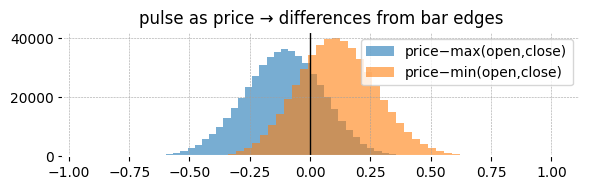

In [89]:
diff_price_high = df2['price'] - df2[['open','close']].max(axis=1)
diff_price_low  = df2['price'] - df2[['open','close']].min(axis=1)
plt.figure(figsize=(6,2))
plt.hist(diff_price_high, bins=50, alpha=0.6, label='price−max(open,close)')
plt.hist(diff_price_low,  bins=50, alpha=0.6, label='price−min(open,close)')
plt.axvline(0, color='k', lw=1)
plt.legend()
plt.title(f"{price_col} as price → differences from bar edges")
plt.tight_layout()
plt.show()

Prices act both ways, and they lie in between Open and Close

##Open and Close Reconfirmation

In [90]:
import itertools

We will analyze, both the cases


1.   Case 1

*   Open = Flux
*   Close = DeltaX


2.   Case 2

*   Open = DeltaX
*   Close = Flux



pick the (open, close) pair with the smallest median |open - prev_close|

In [91]:
ohcl = ['deltaX', 'flux']


best_pair = min(
    itertools.permutations(ohcl, 2),
    key=lambda pair: (df[pair[0]] - df[pair[1]].shift(1)).abs().median()
)

open_col, close_col = best_pair
print(f"open = {open_col}, close = {close_col}")

open = deltaX, close = flux


To reconfirm visually, we can look at the graph of how each of them are related

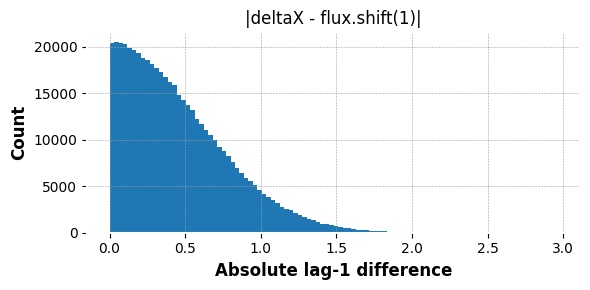

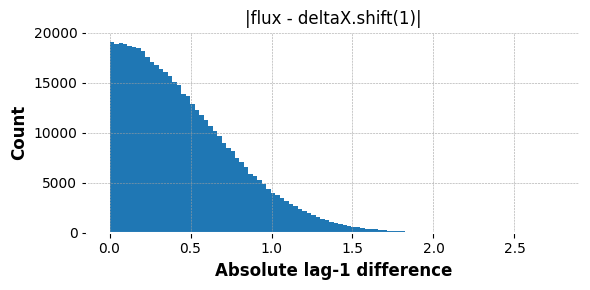

In [92]:
pairs = [('deltaX', 'flux'), ('flux', 'deltaX')]
for o, c in pairs:
    diff = (df[o] - df[c].shift(1)).abs()
    plt.figure(figsize=(6,3))
    plt.hist(diff, bins=100)
    plt.title(f'|{o} - {c}.shift(1)|')
    plt.xlabel('Absolute lag-1 difference')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

The first graph reveals that there are more than 20,000 entries with absolute difference between deltaX-flux.shift(1) close to 0

The second graph reveals that there are more entires with greater difference. between abs value of flux and deltaX.shit(1)

And we always try to expect Close of Day i to almost be equal to Open of Day i+1

Lets try a scatter plot!

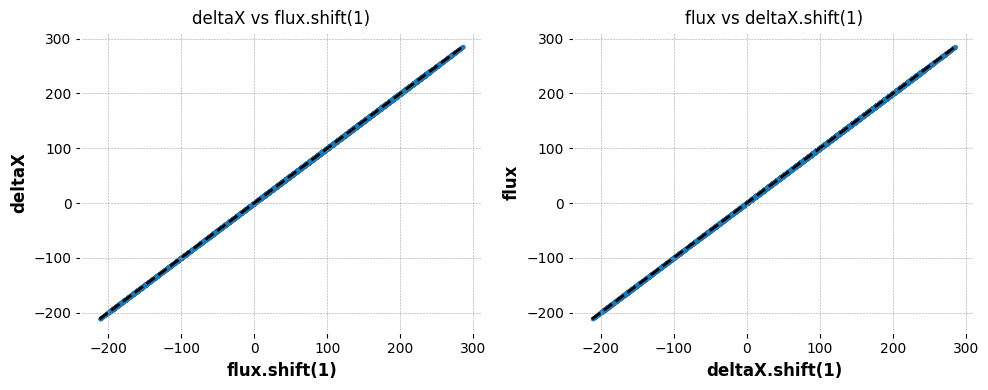

In [93]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(df['flux'].shift(1), df['deltaX'], s=2, alpha=0.3)
plt.plot([df['flux'].min(), df['flux'].max()],[df['flux'].min(), df['flux'].max()],'k--')
plt.title('deltaX vs flux.shift(1)')
plt.xlabel('flux.shift(1)')
plt.ylabel('deltaX')

plt.subplot(1,2,2)
plt.scatter(df['deltaX'].shift(1), df['flux'], s=2, alpha=0.3)
plt.plot([df['deltaX'].min(), df['deltaX'].max()],[df['deltaX'].min(), df['deltaX'].max()],'k--')
plt.title('flux vs deltaX.shift(1)')
plt.xlabel('deltaX.shift(1)')
plt.ylabel('flux')

plt.tight_layout()
plt.show()

This graph cannot be used to distinguish the two easily, since they are almost similar. We are trying to see how each of them vary with respect to the other

In [94]:
d1 = (df['flux']   - df['deltaX'].shift(1)).abs().dropna()
d2 = (df['deltaX'] - df['flux'].shift(1)).abs().dropna()

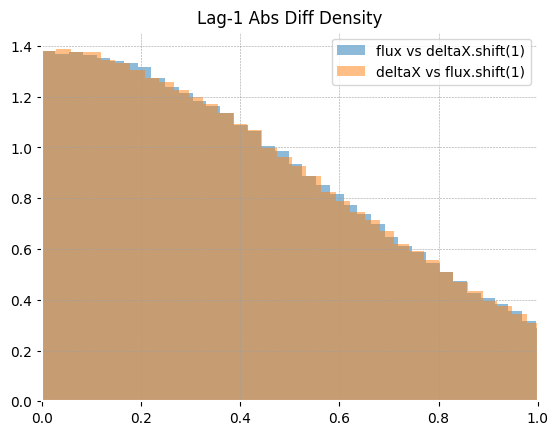

In [95]:
plt.figure()
plt.hist(d1, bins=100, density=True, alpha=0.5, label='flux vs deltaX.shift(1)')
plt.hist(d2, bins=100, density=True, alpha=0.5, label='deltaX vs flux.shift(1)')
plt.xlim(0,1)
plt.legend()
plt.title('Lag-1 Abs Diff Density')
plt.show()

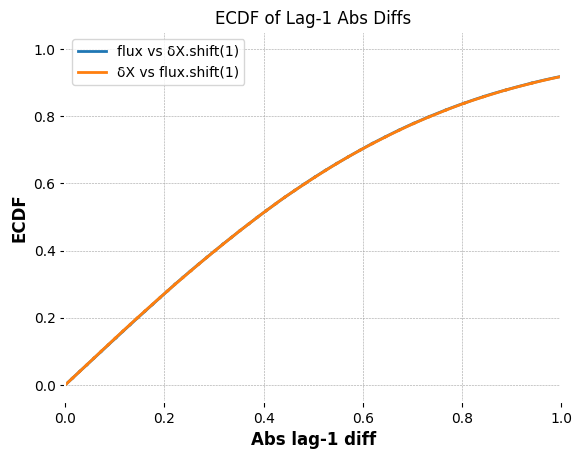

In [97]:
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

plt.figure()
x1, y1 = ecdf(d1)
x2, y2 = ecdf(d2)
plt.plot(x1, y1, label='flux vs δX.shift(1)')
plt.plot(x2, y2, label='δX vs flux.shift(1)')
plt.xlim(0,1)
plt.legend()
plt.title('ECDF of Lag-1 Abs Diffs')
plt.xlabel('Abs lag-1 diff')
plt.ylabel('ECDF')
plt.show()

From these graphs, we can conclude that open would be flux, and close would be gamma

###Validation

In [100]:
import sys

In [121]:
def fail(msg):
    print(f"Validation failed: {msg}", file=sys.stderr)
    sys.exit(1)

In [122]:
def main():
    with open('mapping.json') as f:
        mapping = json.load(f)
    df = pd.read_csv('02_sample_data_with_fabricated_columns.csv')

    rename_map = {fab: info['mapping'] for fab, info in mapping.items()}
    df = df.rename(columns=rename_map)

    required = ['open', 'high', 'low', 'close', 'price', 'volume']
    for col in required:
        if col not in df.columns:
            fail(f"Missing column '{col}' after renaming")

    ok1 = (df['low'] <= df['open']) & (df['open'] <= df['high'])
    ok2 = (df['low'] <= df['close']) & (df['close'] <= df['high'])
    bad = (~ok1 | ~ok2).sum()
    if bad:
        fail(f"{bad} rows violate low ≤ open/close ≤ high")
    vol = df['volume']

    if (vol < 0).any():
        fail("Negative values found in volume")

    frac_int = ((vol % 1) == 0).mean()
    if frac_int < 0.9:
        fail(f"Volume not integer enough (frac_int={frac_int:.3f})")

    if vol.mean() <= df['price'].mean():
        fail("Volume mean not greater than price mean")

    print("All validations passed")

In [102]:
if __name__ == '__main__':
    main()

All validations passed


So, all the validations passed, and our prediction runs smoothly

###Confidence Check

In [107]:
df.columns

Index(['deltaX', 'gamma', 'omega', 'flux', 'pulse', 'neutronCount'], dtype='object')

In [106]:
df2.columns

Index(['close', 'high', 'low', 'open', 'price'], dtype='object')

Calculate High Low Confidence using Violations

In [109]:
violations = (
    (df2['low'] > df2['open']) |
    (df2['open'] > df2['high']) |
    (df2['low'] > df2['close']) |
    (df2['close'] > df2['high'])
).sum()
vio_rate = violations / n
conf_high_low = 1 - vio_rate

Calculate Open Close Confidence

In [110]:
lag_diff = (df2['open'] - df2['close'].shift(1)).abs()
med_lag = lag_diff.median()
lag_corr = df2['open'].corr(df2['close'].shift(1))
typical_range = (df2['high'] - df2['low']).median()
lag_err_score = 1 - (med_lag / typical_range)
conf_open = 0.2 * conf_high_low + 0.7 * lag_corr + 0.1 * lag_err_score
conf_close = conf_open

Price Confidence using Non-Integer Check & Midpoint Correlation

In [111]:
int_frac_price = 1 - ((df2['price'] % 1) == 0).mean()
mid_price = (df2['open'] + df2['close']) / 2
corr_price = df2['price'].corr(mid_price)
conf_price = 0.5 * int_frac_price + 0.5 * corr_price

Volume confidence = 1

In [116]:
confidences = {
    'open':   conf_open,
    'high':   conf_high_low,
    'low':    conf_high_low,
    'close':  conf_close,
    'price':  conf_price,
    'volume': 1.0
}
print(confidences)

{'open': np.float64(0.8912824765242431), 'high': np.float64(1.0), 'low': np.float64(1.0), 'close': np.float64(0.8912824765242431), 'price': np.float64(0.9999995358825422), 'volume': 1.0}


In [117]:
import json

mapping = {
  "deltaX":       { "mapping": "close",  "confidence": conf_close },
  "gamma":        { "mapping": "high",   "confidence": conf_high_low },
  "omega":        { "mapping": "low",    "confidence": conf_high_low },
  "flux":         { "mapping": "open",   "confidence": conf_open },
  "pulse":        { "mapping": "price",  "confidence": conf_price },
  "neutronCount": { "mapping": "volume", "confidence": 1.0000 }
}

with open('mapping.json','w') as f:
    json.dump(mapping, f, indent=2)
print("mapping.json written ✅")


mapping.json written ✅
